In [1]:
#---------------------------------------------------------------------------------------------LIBRARIES--------------------------------------------------------------------------------------------                                                                                         #import OpenCV2 library for image processing and algorithms
import math
import csv 
import numpy as np                                                                                     #import numpy mathematical library
import pandas as pd
import pickle
import random
import matplotlib.pyplot as plt      #import matplotlib library for plotting
from micromlgen import port

from IPython.core.display import display, HTML                                    
display(HTML("<style>.container { width:100% !important; }</style>"))                                  #change width of Jupyer Notebook to use the whole window resolution availab

# import the classifier
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay

In [2]:
def save_statistics(clf, X_test, y_test, csv_filename, confusion_matrix_filename, metrics_filename):
    y_pred = []
    with open(csv_filename, "a", newline='') as fp:
        for row in X_test:
            result = int((str(clf.predict(row.reshape(1, -1))).replace('[','').replace(']','')))
            y_pred.append(result)
            wr = csv.writer(fp, dialect='excel')
            wr.writerow([result])
    fp.close()
    
    #https://www.baeldung.com/cs/multi-class-f1-score
    #https://stackoverflow.com/questions/31421413/how-to-compute-precision-recall-accuracy-and-f1-score-for-the-multiclass-case
    precision, recall, fscore, support = score(y_test.ravel(), y_pred)
    
    #https://towardsdatascience.com/understanding-the-confusion-matrix-from-scikit-learn-c51d88929c79
    #https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9
    metrics = {"Accuracy: " : clf.score(X_test, y_test.ravel()),
               "F1 Score Weighted: " : f1_score(y_test, y_pred, average='weighted'), 
               "F1 Score per Class: " : fscore,
               "Precision per Class: " : precision,
               "Recall per Class: " : recall,
               "Support:  " : support}
    
    cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    disp.plot()
    plt.savefig(confusion_matrix_filename, dpi=500)                                                                                     #https://stackoverflow.com/questions/9622163/save-plot-to-image-file-instead-of-displaying-it-using-matplotlib
    plt.show()
    
    print("CLASSES: Clear = 0, Rain = 1, Partially Cloudy = 2, Overcast = 3, Snow = 4" + "\n")
    with open(metrics_filename, 'w') as f:
        for k, v in metrics.items():
            f.write(str(k) + str(v) + '\n\n')
            print(str(k) + str(v))
    f.close()

Your Train Dataset is:  weather_data_2000_2019
Your Test Dataset is:  weather_data_2020_2021
Please choose 1 to display the dataset or any button to cotinue without displaying!3
Not displaying dataset!
Please choose 1 for Training and 2 for Random CV Search. 
                       Pressing 3 will load the optimised XGBoost Classifier model!3
Parameters Classifier Loaded:  {'objective': 'multi:softprob', 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'enable_categorical': False, 'gamma': 0, 'gpu_id': -1, 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.05, 'max_delta_step': 0, 'max_depth': 4, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 100, 'n_jobs': 20, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': None, 'subsample': 1, 'tree_method': 'exact', 'validate_parame

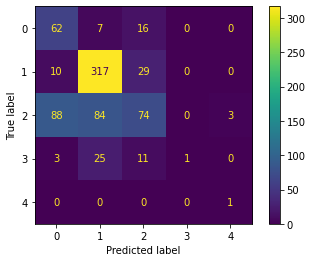

CLASSES: Clear = 0, Rain = 1, Partially Cloudy = 2, Overcast = 3, Snow = 4

Accuracy: 0.6224350205198358
F1 Score Weighted: 0.5857037200607172
F1 Score per Class: [0.5        0.8035488  0.39050132 0.04878049 0.4       ]
Precision per Class: [0.3803681  0.73210162 0.56923077 1.         0.25      ]
Recall per Class: [0.72941176 0.89044944 0.29718876 0.025      1.        ]
Support:  [ 85 356 249  40   1]


In [4]:
def main():
    #dataset selection and loading
    train_set_name = "weather_data_2000_2019"
    train_dataset = pd.read_csv(("./datasets/" + train_set_name + ".csv"),header=None)
    test_set_name = "weather_data_2020_2021"
    test_dataset = pd.read_csv(("./datasets/" + test_set_name + ".csv"),header=None) 

    print("Your Train Dataset is: ", train_set_name)                                                                       #display dataset name to user
    print("Your Test Dataset is: ", test_set_name)                                                                       #display dataset name to user

    features_selected = 6
    #training features
    temperature_train = train_dataset.iloc[:, 4:5]
    feels_like_train = train_dataset.iloc[:, 7:8]
    dew_point_train = train_dataset.iloc[:, 8:9]
    humidity_train = train_dataset.iloc[:, 9:10]
    pressure_train = train_dataset.iloc[:, 19:20] 
    uv_index_train = train_dataset.iloc[:, 24:25] 

    #testing data
    temperature_test = test_dataset.iloc[:, 4:5]
    feels_like_test = test_dataset.iloc[:, 7:8]
    dew_point_test = test_dataset.iloc[:, 8:9]
    humidity_true = test_dataset.iloc[:, 9:10]
    pressure_test = test_dataset.iloc[:, 19:20]
    uv_index_test = test_dataset.iloc[:, 24:25] 

    X_train = pd.concat([temperature_train, feels_like_train, dew_point_train, humidity_train, pressure_train, uv_index_train], axis=1)
    X_train.replace(([np.inf, -np.inf], np.nan), inplace=True)                                                            #replace any infinite values with nan
    X_train = X_train.to_numpy()  


    y_train = train_dataset.iloc[:, 30:31].to_numpy()
    y_true = test_dataset.iloc[:, 30:31].to_numpy()

    #https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html
    test_data = pd.concat([temperature_test, feels_like_test, dew_point_test, humidity_true, pressure_test, uv_index_test], axis=1)       
    test_data.replace(([np.inf, -np.inf], np.nan), inplace=True)                                                            #replace any infinite values with nan
    X_test = test_data.to_numpy()

    #change all nan values in all datasets with the most frequent value of the dataset
    imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    imp.fit(X_train)
    imp.fit(y_train)
    imp.fit(X_test)
    imp.fit(y_true)

    disp = int(input("Please choose 1 to display the dataset or any button to cotinue without displaying!"))
    if disp == 1:
        display(X_train)
        display(y_train.ravel())

        display(X_test)
    else: print("Not displaying dataset!")   

    #------------------------------------------------------------------------------------------
    #https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html
    #https://www.analyticsvidhya.com/blog/2021/11/implementation-of-gaussian-naive-bayes-in-python-sklearn/
    choice = int(input("""Please choose 1 for Training and 2 for Random CV Search. 
                       Pressing 3 will load the optimised XGBoost Classifier model!"""))
    clf_type = "default" if choice == 1 else "optimised"
    model_name = "./trained_models/xgb_optimised_" + train_set_name + "_" + test_set_name + "_" + str(features_selected) + "f.p"
    confusion_matrix_filename = "./confusion_matrix/xgb_" + str(clf_type) + "_" + train_set_name + "_"  + test_set_name + "_" + str(features_selected) + "f.png"
    metrics_filename = "./metrics/xgb_" + str(clf_type) + "_" + train_set_name + "_"  + test_set_name + "_" + str(features_selected) + "f.txt"
    csv_filename = "./outputs/output_xgb_"  + str(clf_type) + "_" + train_set_name + "_"  + test_set_name + "_" + str(features_selected) + "f.csv"

    if choice == 1:
        # Create XGBoost classifer object and train it on the selected dataset
        xgb = (XGBClassifier(objective = 'multi:softmax', eval_metric = 'merror')).fit(X_train, y_train.ravel())
        save_statistics(xgb, X_test, y_true, csv_filename, confusion_matrix_filename, metrics_filename)

    elif choice == 2:
        #random search: https://www.kaggle.com/tilii7/hyperparameter-grid-search-with-xgboost
        #grid search: https://www.mikulskibartosz.name/xgboost-hyperparameter-tuning-in-python-using-grid-search/
        #label encoder warning: https://stackoverflow.com/questions/45251126/deprecation-warning-on-xgboost-sklearn
        estimator = XGBClassifier(objective = 'multi:softmax', nthread = 20, seed = 42, num_class = 5, eval_metric = 'merror')
        parameters = {'max_depth': range (2, 10, 1),'n_estimators': range(60, 220, 40),'learning_rate': [0.1, 0.01, 0.05]}

        grid_search = GridSearchCV(estimator=estimator, param_grid=parameters, cv = 5, verbose = True,  refit = True)
        grid_search.fit(X_train, y_train.ravel())
        
        print(grid_search.best_params_)
        print(grid_search.best_estimator_)
        pickle.dump(grid_search.best_estimator_, open(model_name, "wb"))

    elif choice == 3:
        xgb = pickle.load(open(model_name, "rb"))
        print("Parameters Classifier Loaded: ", xgb.get_params())

        save_statistics(xgb, X_test, y_true, csv_filename, confusion_matrix_filename, metrics_filename)

if __name__ == "__main__":                                                                                               #guard boilerplate
    main()